# Robustness Analysis: Adjoint and Toggle-Frame Objectives Subject to Either Multiplicative or Additive Errors

This notebook compares the performance of the adjoint and toggling-frame robustness objectives for multiplicative and additive error terms in the system's Hamiltonian. 

## Imports

In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();
Pkg.develop(path="../../QuantumCollocation.jl")
using PiccoloQuantumObjects
using QuantumCollocation
using ForwardDiff
using LinearAlgebra
using Plots
using SparseArrays
using Statistics
using CairoMakie
using Random

  Activating project at `~/Documents/research/pulses/project/notebooks/src`
   Resolving package versions...
  No Changes to `~/Documents/research/pulses/project/notebooks/src/Project.toml`
  No Changes to `~/Documents/research/pulses/project/notebooks/src/Manifest.toml`


In [8]:
# Problem parameters
T = 50
Δt = 0.2
U_goal = GATES.X
H_drive = [PAULIS.X, PAULIS.Y]
piccolo_opts = PiccoloOptions(verbose=false)
pretty_print(X::AbstractMatrix) = Base.show(stdout, "text/plain", X);
sys = QuantumSystem(H_drive)

QuantumSystem: levels = 2, n_drives = 2

sanity checks for our good ole adjoint

In [3]:
propertynames(sys)

(:H, :G, :n_drives, :levels, :params)

In [4]:
typeof(sys.H)

PiccoloQuantumObjects.QuantumSystems.var"#6#15"{SparseMatrixCSC{ComplexF64, Int64}, Vector{SparseMatrixCSC{ComplexF64, Int64}}}

In [5]:
length(sys.H.H_drives)
X_drive = sys.H.H_drives[1]
X_drive === H_drive[1]

false

In [9]:
Random.seed!(5)

#Default
def = UnitarySmoothPulseProblem(sys, U_goal, T, Δt; Q_t=1.0)
solve!(def, max_iter=250, print_level=5)

#Adjoint
∂ₑHₐ = PAULIS.X
varsys_add = VariationalQuantumSystem(
    H_drive,
    [∂ₑHₐ]
)

# Multiplicative error template
# H = aX
# H_drive_m = a -> a[1] * H_drive
# H_vars_array = Function[H_drive_m]

varsys_mult = VariationalQuantumSystem(
    a -> a[1] * PAULIS.X + a[2] * PAULIS.Y,
    Function[a -> a[1] * PAULIS.X],
    2
)

varsys_both = VariationalQuantumSystem(
    a -> a[1] * PAULIS.X + a[2] * PAULIS.Y,
    Function[a -> a[1] * PAULIS.X, a -> PAULIS.X],
    2
)

varadd_prob = UnitaryVariationalProblem(
        varsys_add, U_goal, T, Δt;
        robust_times=[[T]],
        piccolo_options=piccolo_opts
    )
solve!(varadd_prob, max_iter=250, print_level=5)

varmult_prob = UnitaryVariationalProblem(
        varsys_mult, U_goal, T, Δt;
        robust_times=[[T]],
        piccolo_options=piccolo_opts
    )
solve!(varmult_prob, max_iter=250, print_level=5)

varboth_prob = UnitaryVariationalProblem(
        varsys_both, U_goal, T, Δt;
        robust_times=[[T]],
        dda_bound = 2.0,
        piccolo_options=piccolo_opts
    )
solve!(varboth_prob, max_iter=250, print_level=5)

#Toggling

Hₑ_add = a -> PAULIS.X
add_prob = UnitaryToggleProblem(
    sys, U_goal, T, Δt, Hₑ_add;
    piccolo_options=piccolo_opts
    )
solve!(add_prob, max_iter=250, print_level=5)

X_drive = sys.H.H_drives[1]
Hₑ_mult = a -> a[1] * X_drive

mult_prob = UnitaryToggleProblem(
    sys, U_goal, T, Δt, Hₑ_mult;
    piccolo_options=piccolo_opts
    )
solve!(mult_prob, max_iter=250, print_level=5)


Hₑ_both = a -> PAULIS.X + a[1] * X_drive
both_prob = UnitaryToggleProblem(
    sys, U_goal, T, Δt, Hₑ_both;
    piccolo_options=piccolo_opts
    )
solve!(both_prob, max_iter=250, print_level=5)



    constructing UnitarySmoothPulseProblem...
	using integrator: typeof(UnitaryIntegrator)
	control derivative names: [:da, :dda]
	applying timesteps_all_equal constraint: Δt
    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of Ũ⃗
        applying constraint: initial value of a
        applying constraint: final value of a
        applying constraint: bounds on a
        applying constraint: bounds on da
        applying constraint: bounds on dda
        applying constraint: bounds on Δt

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, runnin

In [7]:
using TrajectoryIndexingUtils
a_indices  = [collect(slice(k, both_prob.trajectory.components.a, both_prob.trajectory.dim)) for k in 1:both_prob.trajectory.T]
a_ref = ones(length(both_prob.trajectory.components.a))
norm(Hₑ_mult(a_ref), 2)

1.4142135623730951

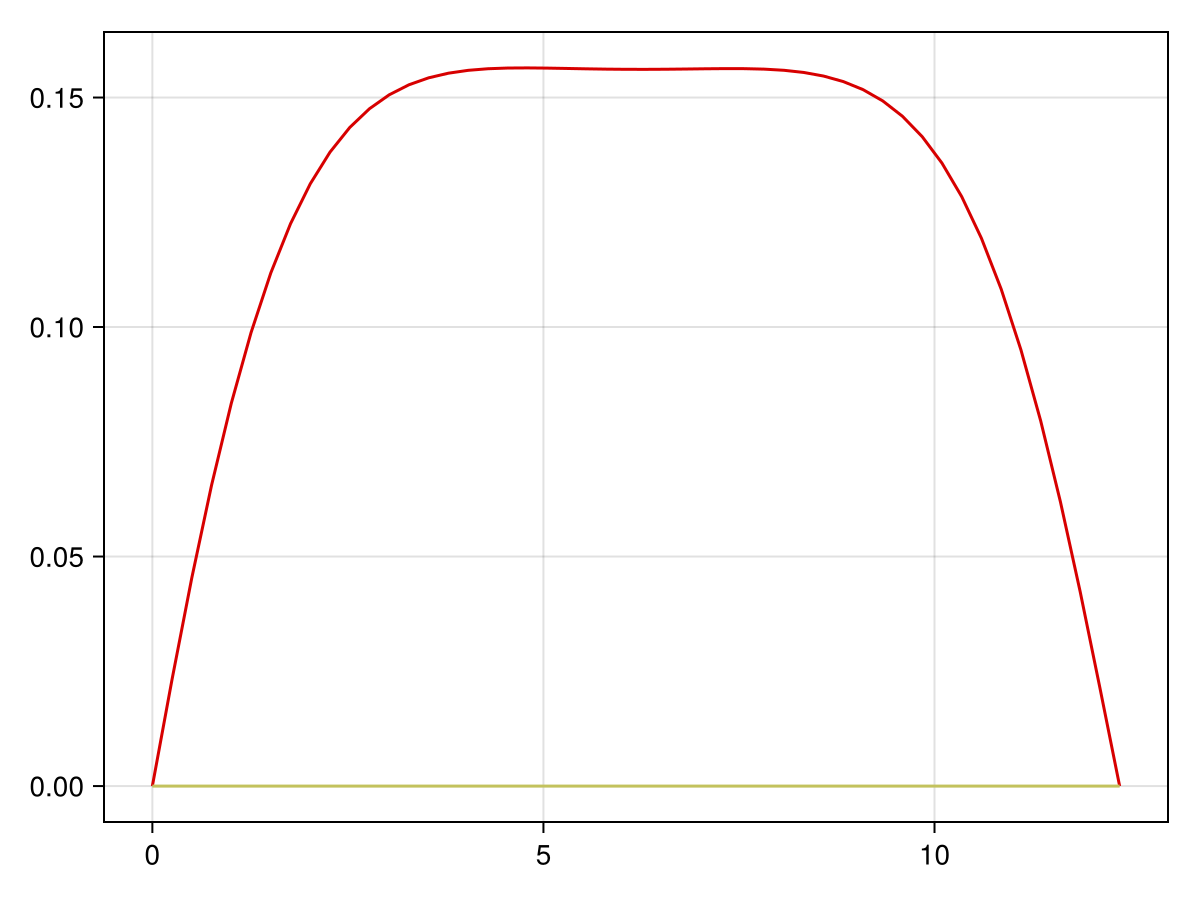

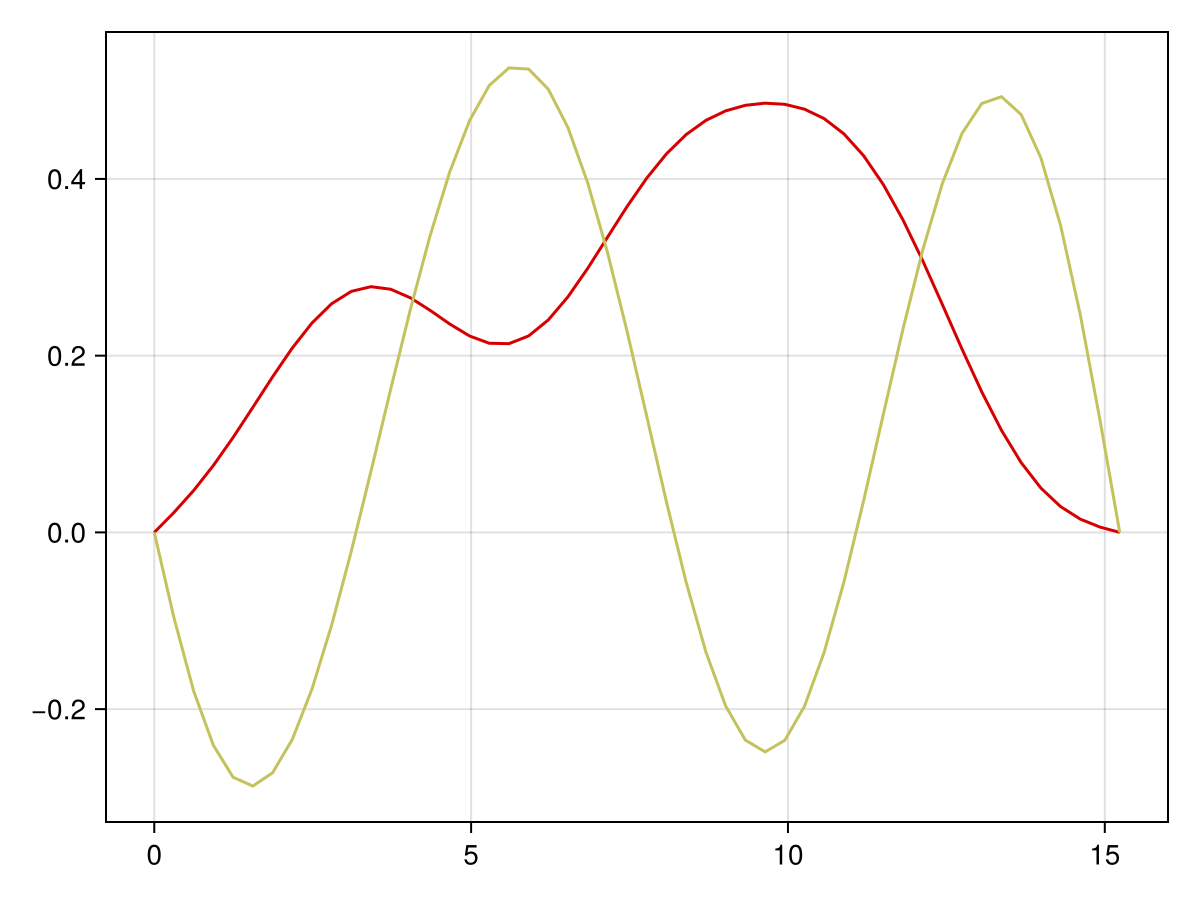

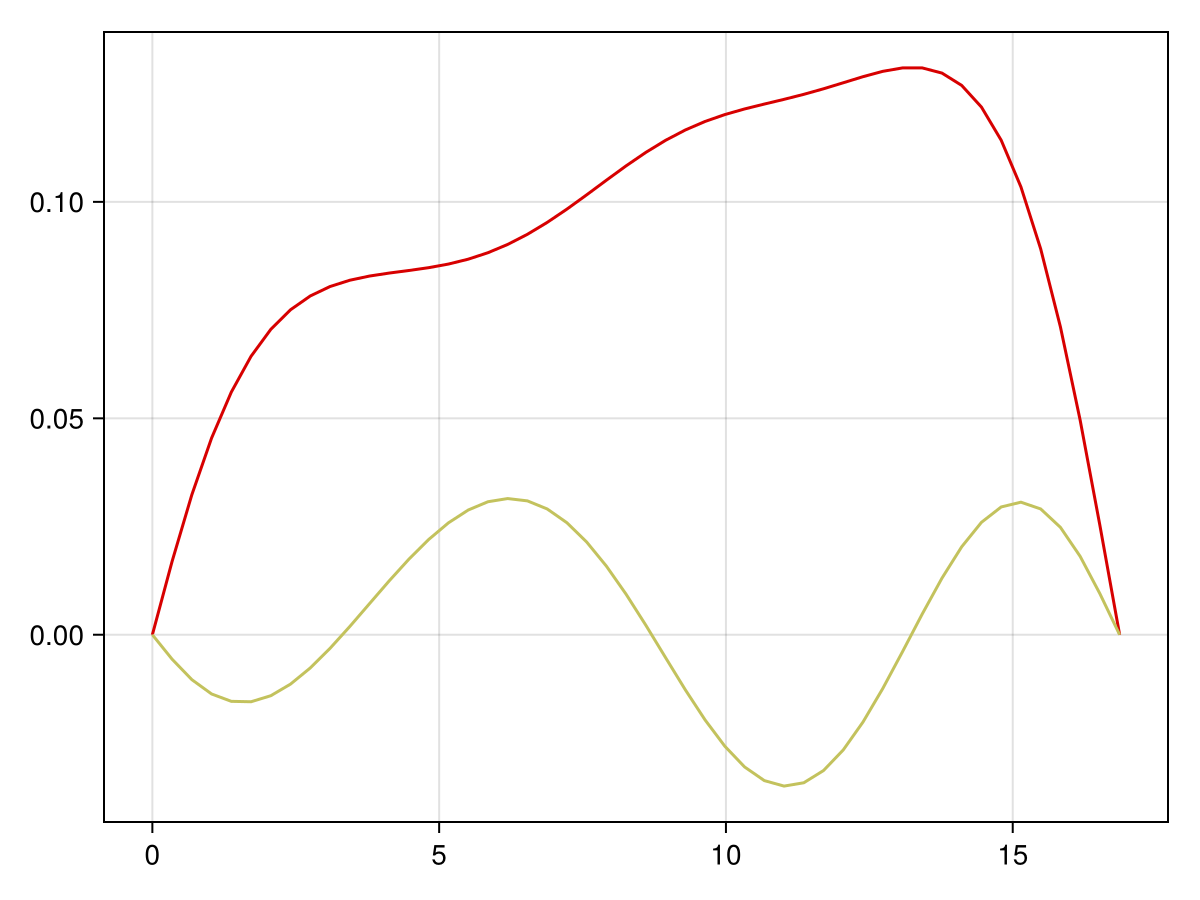

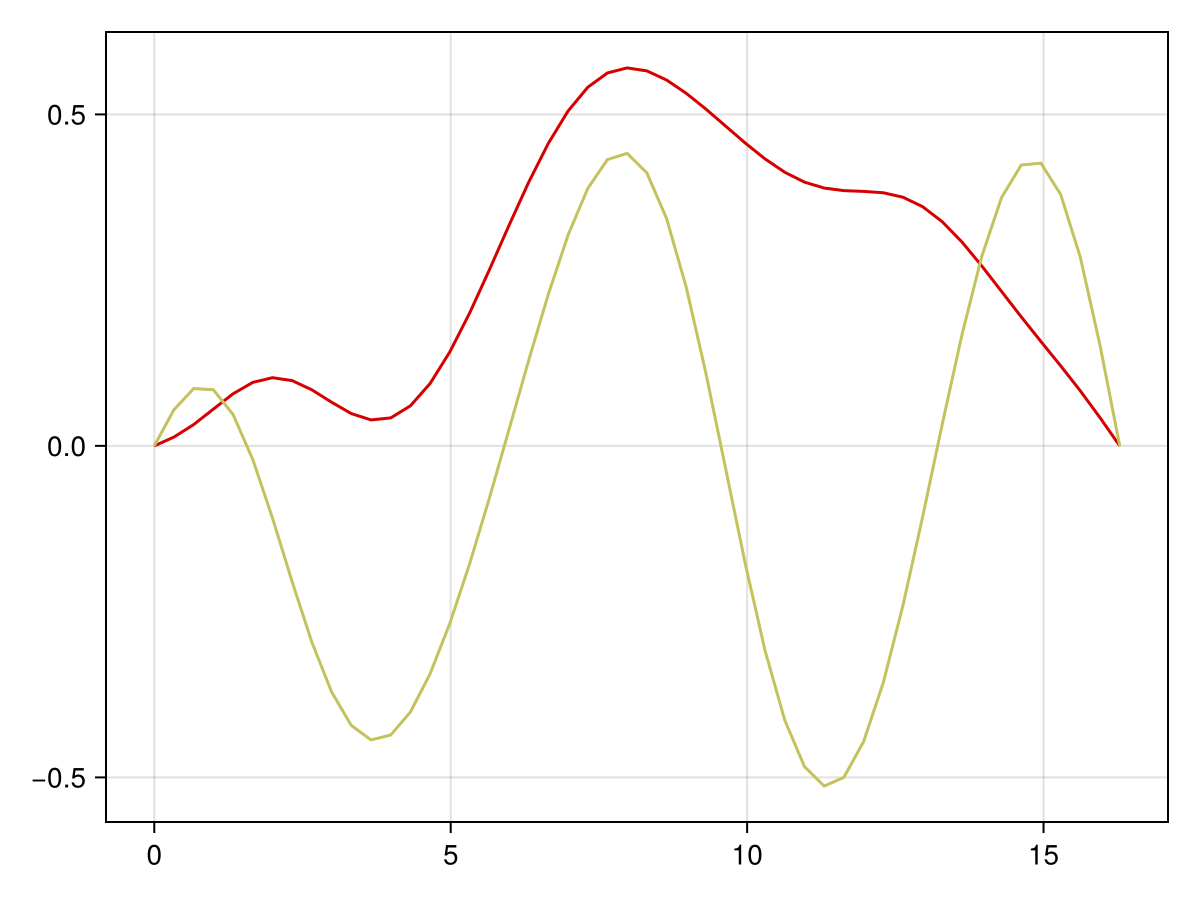

CairoMakie.Screen{IMAGE}


In [10]:
display(CairoMakie.plot(def.trajectory, :a))
display(CairoMakie.plot(add_prob.trajectory, :a))
display(CairoMakie.plot(mult_prob.trajectory, :a))
display(CairoMakie.plot(both_prob.trajectory, :a))

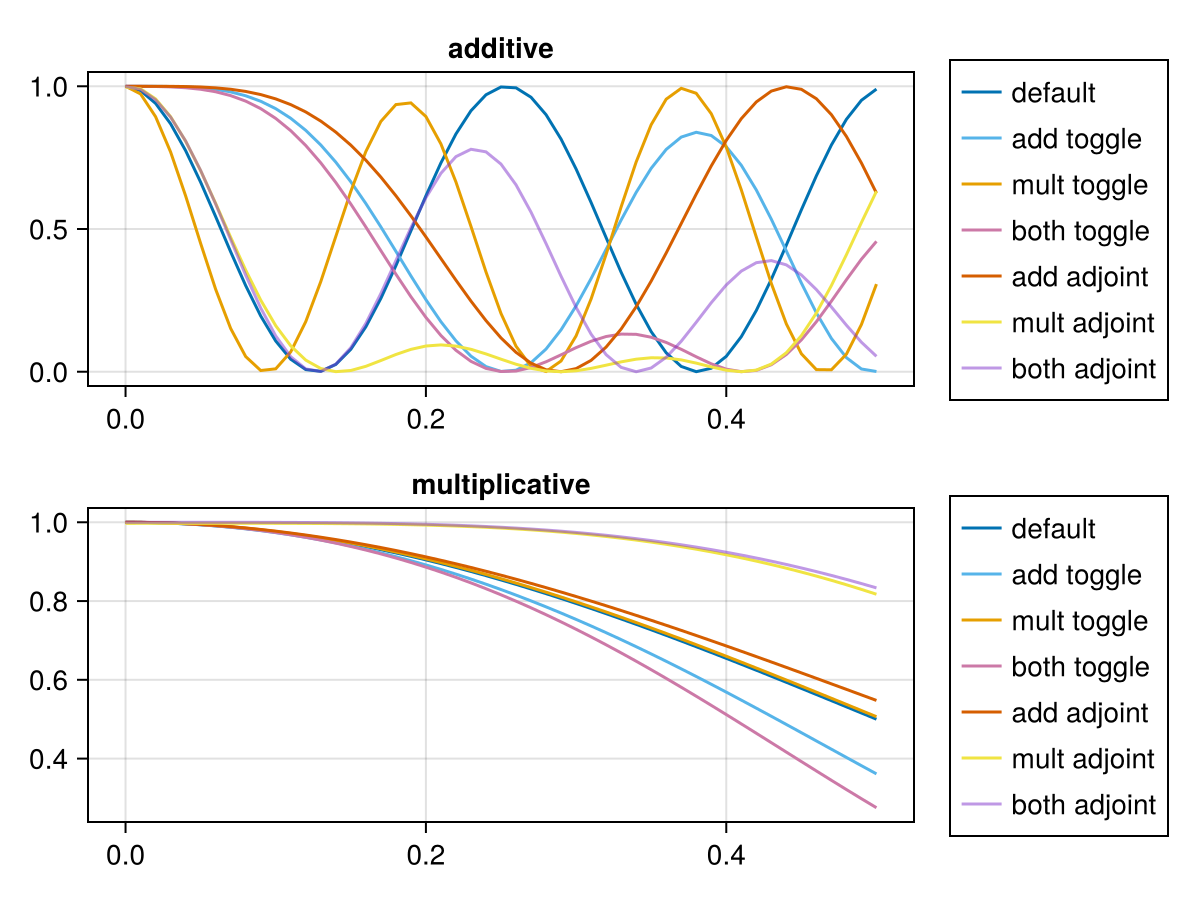

In [11]:
H_drive_add = H_drive

f = Figure()
ax1 = Axis(f[1, 1], title="additive")
ax2 = Axis(f[2, 1], title="multiplicative")

colors = Makie.wong_colors()

εs = 0:0.01:.5

# default case (smooth, non-variational, w/o toggling obj)

ys = [unitary_rollout_fidelity(def.trajectory, QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])) for ε in εs]
lines!(ax1, εs, ys, label="default", color=colors[1], linestyle=:solid)

ys = [unitary_rollout_fidelity(def.trajectory, QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])) for ε in εs]
lines!(ax2, εs, ys, label="default", color=colors[1], linestyle=:solid)

# toggling obj

# (add)
ys = [unitary_rollout_fidelity(add_prob.trajectory, QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])) for ε in εs]
lines!(ax1, εs, ys, label="add toggle", color=colors[5], linestyle=:solid)

ys = [unitary_rollout_fidelity(add_prob.trajectory, QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])) for ε in εs]
lines!(ax2, εs, ys, label="add toggle", color=colors[5], linestyle=:solid)

# (mult)
ys = [unitary_rollout_fidelity(mult_prob.trajectory, QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])) for ε in εs]
lines!(ax1, εs, ys, label="mult toggle", color=colors[2], linestyle=:solid)

ys = [unitary_rollout_fidelity(mult_prob.trajectory, QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])) for ε in εs]
lines!(ax2, εs, ys, label="mult toggle", color=colors[2], linestyle=:solid)

# (both)
ys = [unitary_rollout_fidelity(both_prob.trajectory, QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])) for ε in εs]
lines!(ax1, εs, ys, label="both toggle", color=colors[4], linestyle=:solid)

ys = [unitary_rollout_fidelity(both_prob.trajectory, QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])) for ε in εs]
lines!(ax2, εs, ys, label="both toggle", color=colors[4], linestyle=:solid)

# adjoint obj

# (add)
ys = [unitary_rollout_fidelity(varadd_prob.trajectory, QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])) for ε in εs]
lines!(ax1, εs, ys, label="add adjoint", color=colors[6], linestyle=:solid)

ys = [unitary_rollout_fidelity(varadd_prob.trajectory, QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])) for ε in εs]
lines!(ax2, εs, ys, label="add adjoint", color=colors[6], linestyle=:solid)

# (mult)
ys = [unitary_rollout_fidelity(varmult_prob.trajectory, QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])) for ε in εs]
lines!(ax1, εs, ys, label="mult adjoint", color=colors[7], linestyle=:solid)

ys = [unitary_rollout_fidelity(varmult_prob.trajectory, QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])) for ε in εs]
lines!(ax2, εs, ys, label="mult adjoint", color=colors[7], linestyle=:solid)

# (both)
ys = [unitary_rollout_fidelity(varboth_prob.trajectory, QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])) for ε in εs]
lines!(ax1, εs, ys, label="both adjoint", color=RGBAf(0.5, 0.2, 0.8, 0.5), linestyle=:solid)

ys = [unitary_rollout_fidelity(varboth_prob.trajectory, QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])) for ε in εs]
lines!(ax2, εs, ys, label="both adjoint", color=RGBAf(0.5, 0.2, 0.8, 0.5), linestyle=:solid)


Legend(f[1,2], ax1, position=:lb)
Legend(f[2,2], ax2, position=:lb)

f


single seed check

single pareto frontier for sanity check 

Full seed

In [12]:
n_guesses = 4
n_drives = sys.n_drives
a_guess = [0.5*randn(2, T) for _ in 1:n_guesses]
a_bounds = fill(1/Δt, n_drives)
da_bounds = fill(1.0, n_drives)
dda_bounds = fill(2.0, n_drives)
control_bounds = (a_bounds, da_bounds, dda_bounds)
def_seeds = []
add_seeds = []
mult_seeds = []
both_seeds = []
n_seeds = n_guesses


for i in 1:n_seeds
    def_traj = initialize_trajectory(
                    U_goal,
                    T,
                    Δt,
                    n_drives,
                    control_bounds;
                    a_guess=deepcopy(a_guess[i]),
                    system=sys
                )
    push!(def_seeds, def_traj)

    add_traj = initialize_trajectory(
                    U_goal,
                    T,
                    Δt,
                    n_drives,
                    control_bounds;
                    a_guess=deepcopy(a_guess[i]),
                    system=sys
                )
    push!(add_seeds, add_traj)

    mult_traj = initialize_trajectory(
                U_goal,
                T,
                Δt,
                n_drives,
                control_bounds;
                a_guess=deepcopy(a_guess[i]),
                system=sys
            )
    push!(mult_seeds, mult_traj)

    both_traj = initialize_trajectory(
                U_goal,
                T,
                Δt,
                n_drives,
                control_bounds;
                a_guess=deepcopy(a_guess[i]),
                system=sys
            )
    push!(both_seeds, both_traj)
end



In [44]:
final_fid_floor = [1-10.0^(-a) for a in 2:1:5]
n_nines = length(final_fid_floor)
default_probs = Matrix{Any}(undef, n_seeds, n_nines)
init_add_probs = Matrix{Any}(undef, n_seeds, n_nines)
init_mult_probs = Matrix{Any}(undef, n_seeds, n_nines)
init_both_probs = Matrix{Any}(undef, n_seeds, n_nines)


for i in 1:n_seeds
    for j in 1:n_nines
        n_iters = 100 + 25*j
        default = UnitarySmoothPulseProblem(sys, U_goal, T, Δt; a_guess=deepcopy(a_guess[i]))
        solve!(default; max_iter=n_iters, print_level=5)
        default_probs[i, j] = default

        add_tog_prob = UnitarySmoothPulseProblem(sys, U_goal, T, Δt; a_guess=deepcopy(a_guess[i]))
        solve!(add_tog_prob; max_iter=n_iters, print_level=5)
        init_add_probs[i,j] = add_tog_prob

        mult_tog_prob = UnitarySmoothPulseProblem(sys, U_goal, T, Δt; a_guess=deepcopy(a_guess[i]))
        solve!(mult_tog_prob; max_iter=n_iters, print_level=5)
        init_mult_probs[i,j] = mult_tog_prob
    end
end


Plot Fid vs. error magnitude

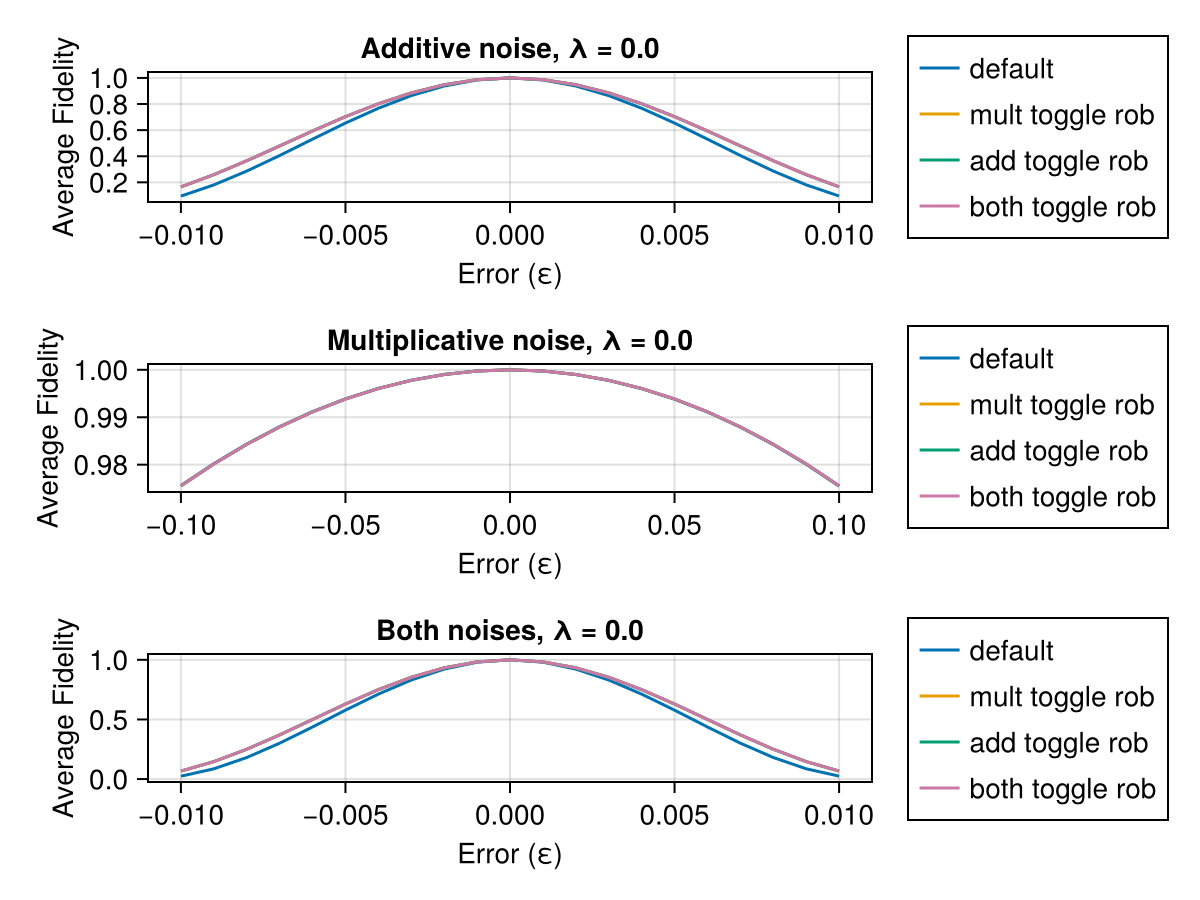

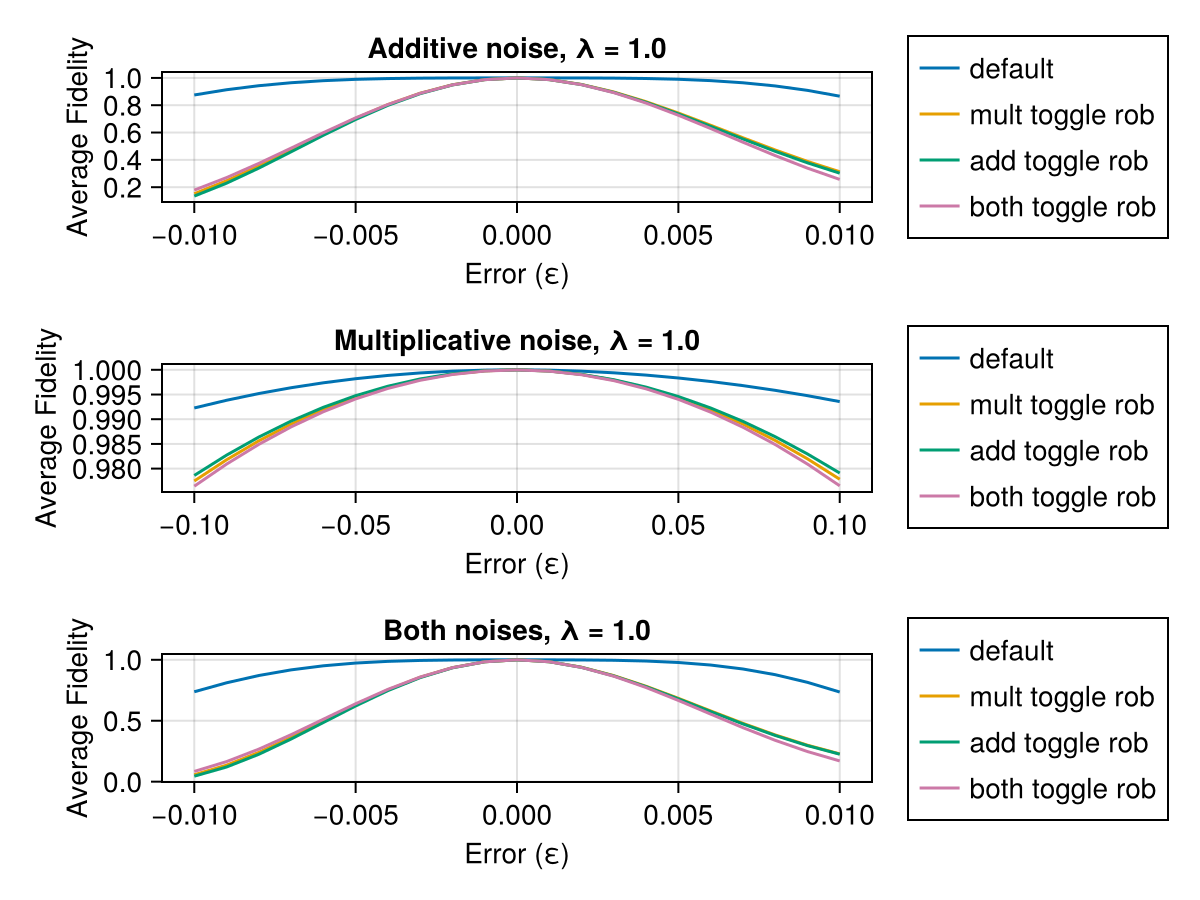

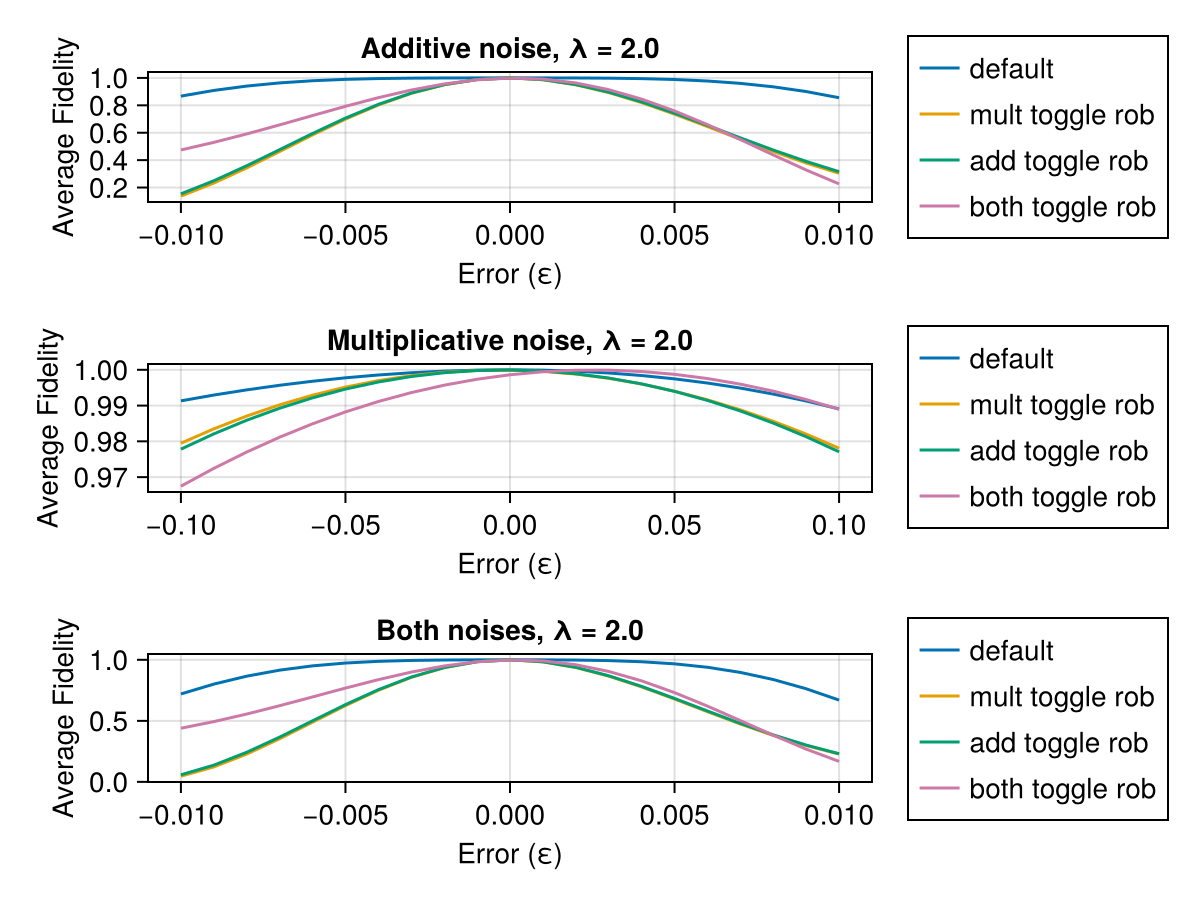

In [46]:
H_drive_add = H_drive
εs = 0:0.005:0.2
colors = Makie.wong_colors()

# Plot for each fid
for seed_idx in 1:n_seeds
    for (f, j) in final_fid_floor

        f = Figure()
        ax1 = Axis(f[1, 1], title="Additive noise, min_fid = $f", xlabel="Error (ε)", ylabel="Average Fidelity")
        ax2 = Axis(f[2, 1], title="Multiplicative noise, min_fid = $f", xlabel="Error (ε)", ylabel="Average Fidelity")
        # ax3 = Axis(f[3, 1], title="Both noises, λ = $λ", xlabel="Error (ε)", ylabel="Average Fidelity")

        # Define system functions for additive and multiplicative noise
        additive_system = ε -> QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])
        multiplicative_system = ε -> QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])
        # both_system = ε -> QuantumSystem(ε * PAULIS.X, [(1 + ε) * PAULIS.X, PAULIS.Y])
        # Plot data structure: (matrix, label, color)
        plot_configs = [
            (default_probs, "default", colors[1]),
            (init_add_probs, "add warm start", colors[2]),
            (init_mult_probs, "mult warm start", colors[3])#,
            # (both_adj_probs, "both toggle rob", colors[4])
        ]

        # Plot for both noise types
        for (probs_matrix, label, color) in plot_configs
            # Additive noise
            prob = probs_matrix[seed_idx, λ_idx]
            ys_add = [unitary_rollout_fidelity(prob.trajectory, additive_system(ε)) for ε in εs]#0:0.001:0.01]
            lines!(ax1, 0.1*εs, ys_add, label=label, color=color, linestyle=:solid)
            
            # Multiplicative noise
            ys_mult = [unitary_rollout_fidelity(prob.trajectory, multiplicative_system(ε)) for ε in εs]
            lines!(ax2, εs, ys_mult, label=label, color=color, linestyle=:solid)
            
            # # Both noises
            # ys_both = [unitary_rollout_fidelity(prob.trajectory, both_system(ε)) for ε in εs]#0:0.001:0.01]
            # lines!(ax3, 0.1*εs, ys_both, label=label, color=color, linestyle=:solid)
        end

        Legend(f[1, 2], ax1, position=:lb)
        Legend(f[2, 2], ax2, position=:lb)
        # Legend(f[3, 2], ax3, position=:lb)

        display(f)
    end
end


Summary Table

In [47]:
Ũ⃗, Ũ⃗_vars = variational_unitary_rollout(add_prob.trajectory, varsys_mult);
QuantumObjectives.unitary_fidelity_loss(Ũ⃗[:, end], GATES.X) |> println

# Detailed results table
display("\n=== Detailed Results Table ===")
for seed_idx in 1:n_seeds
    display("\nseed idx = $seed_idx:")
    display("Weight λ | Base Fidelity | Add Fidelity | Mult Fidelity | Both")
    display("-" ^ 40)
    for (λ_idx, λ) in enumerate(sweep_rob_loss_λ)
        def_fid = unitary_rollout_fidelity(default_probs[seed_idx, λ_idx].trajectory, sys)
        add_fid = unitary_rollout_fidelity(add_adj_probs[seed_idx, λ_idx].trajectory, varsys_add)
        mult_fid = unitary_rollout_fidelity(mult_adj_probs[seed_idx, λ_idx].trajectory, varsys_mult)
        both_fid = unitary_rollout_fidelity(both_adj_probs[seed_idx, λ_idx].trajectory, varsys_both)
        display("$(lpad(round(λ, digits=4), 7)) | $(lpad(round(def_fid, digits=6), 12)) | $(lpad(round(add_fid, digits=6), 12)) | $(lpad(round(mult_fid, digits=6), 13)) | $(lpad(round(both_fid, digits=6), 12)) |")
    end
end


"\n=== Detailed Results Table ==="

"\nseed idx = 1:"

"Weight λ | Base Fidelity | Add Fidelity | Mult Fidelity | Both"

"----------------------------------------"

"    0.0 |          1.0 |          1.0 |           1.0 |          1.0 |"

"    1.0 |          1.0 |     0.999997 |      0.999994 |     0.999976 |"

"    2.0 |          1.0 |     0.999913 |      0.999955 |     0.998616 |"

In [ ]:
final_fid_floor = [1-10.0^(-a) for a in 2:1:5]
n_nines = length(final_fid_floor)
final_add_probs = Matrix{Any}(undef, n_seeds, n_nines)
final_mult_probs = Matrix{Any}(undef, n_seeds, n_nines)
final_both_probs = Matrix{Any}(undef, n_seeds, n_nines)

for i in 1:n_seeds
    for j in 1:n_nines
        Hₑ_add = a -> PAULIS.X
        add_prob = UnitaryMaxToggleProblem(
                init_add_probs[i,j],  # per-seed warm-start traj
                U_goal,
                Hₑ_add;
                final_fidelity=final_fid_floor,
                piccolo_options=piccolo_opts
            )
        solve!(add_prob, max_iter=150, print_level=5)
        final_add_probs[i,j] = add_prob

        X_drive = sys.H.H_drives[1]
        Hₑ_mult = a -> a[1] * X_drive

        mult_prob = UnitaryMaxToggleProblem(
                init_mult_probs[i,j],  # per-seed warm-start traj
                U_goal,
                Hₑ_mult;
                final_fidelity=final_fid_floor,
                piccolo_options=piccolo_opts
            )
        solve!(mult_prob, max_iter=150, print_level=5)
        final_mult_probs[i,j] = mult_prob

        # Hₑ_both = a -> PAULIS.X + a[1] * X_drive
        # both_prob = UnitaryToggleProblem(
        #     sys, U_goal, T, Δt, Hₑ_both;
        #     piccolo_options=piccolo_opts
        #     )
        # solve!(both_prob, max_iter=150, print_level=5)

    end
end



Pareto Frontiers

In [ ]:
robustness_value(traj::NamedTrajectory, H_err::Function, λ::Float64) = begin
    rob = FirstOrderObjective(H_err, traj; Q_t=λ)  # your safe version
    Z   = vcat(traj.datavec, traj.global_data)
    rob.L(Z)
end
final_add_probs = Matrix{Any}(undef, n_seeds, n_nines)
final_mult_probs

for s in 1:n_seeds
    plt = Plots.plot(
        xlabel="Robustness (FirstOrderObjective)",
        ylabel="Final fidelity",
        title="Additive Error Pareto frontier — seed $s",
        legend=:bottomright, grid=true
    )
    xs = Float64[]
    ys = Float64[]
    for (f, j) in enumerate(lambdas)
        add_prob = final_add_probs[s, j]
        Hₑ_add = a -> PAULIS.X
        obj = FirstOrderObjective(Hₑ_add, add_prob.trajectory)
        Z   = vcat(add_prob.trajectory.datavec, add_prob.trajectory.global_data)
        obj_value = obj.L(Z)
        push!(xs, obj_value)
        push!(ys, unitary_rollout_fidelity(add_prob.trajectory, sys))
    end
    # sort by x for a nice line
    ord = sortperm(xs)
    Plots.plot!(plt, xs[ord], ys[ord], marker=:circle, label=String(name))
    display(plt)
end

for s in 1:n_seeds
    plt = Plots.plot(
        xlabel="Robustness (FirstOrderObjective)",
        ylabel="Final fidelity",
        title="Multiplicative Error Pareto frontier — seed $s",
        legend=:bottomright, grid=true
    )
    xs = Float64[]  # robustness
    ys = Float64[]  # fidelity
    for (f, j) in enumerate(lambdas)
        mult_prob = final_mult_probs[s, j]
        X_drive = sys.H.H_drives[1]
        Hₑ_mult = a -> a[1] * X_drive
        obj = FirstOrderObjective(Hₑ_mult, mult_prob.trajectory)
        Z   = vcat(mult_prob.trajectory.datavec, mult_prob.trajectory.global_data)
        obj_value = obj.L(Z)
        push!(xs, obj_value)
        push!(ys, unitary_rollout_fidelity(mult_prob.trajectory, sys))
    end
    # sort by x for a nice line
    ord = sortperm(xs)
    Plots.plot!(plt, xs[ord], ys[ord], marker=:circle, label=String(name))
    display(plt)
end

In [49]:
# using Plots
# Initialize storage for fidelities for each lambda
final_fid_floor = [1-10.0^(-a) for a in 2:1:5]
n_nines = length(final_fid_floor)
n_seeds = length(a_guess)
templates = [add_adj_probs, mult_adj_probs, both_adj_probs]
# Store fidelities for each lambda and error combination


base_fidelities = zeros(n_seeds, n_nines)
additive_fidelities = zeros(n_seeds, n_nines)
multiplicative_fidelities = zeros(n_seeds, n_nines)
both_fidelities = zeros(n_seeds, n_nines)
obj_vals = zeros(n_seeds, n_nines)


configs = [
            (add_adj_probs, additive_fidelities, varsys_add),
            (mult_adj_probs, multiplicative_fidelities, varsys_mult)#,
            # (both_adj_probs, both_fidelities, varsys_both)
        ]
title_idx = 1
titles = ["Add", "mult", "Both"]

for (probs, fidelities, system) in configs
    println("----------------!New noise model!----------------")
    # Calculate fidelities for each seed
    for seed_idx in 1:n_seeds
        # Calculate fidelities for each lambda
        for (f, j) in enumerate(final_fid_floor)
            
            prob = probs[seed_idx, j]
            println("\nProcessing λ = $λ")
            obj = QuantumObjectives.FirstOrderObjective(Hₑ, prob.trajectory, [T]; Q_t=λ)#prob.trajectory.Ũ⃗ᵥ1[:, end]
            Z_vec = vec(prob.trajectory)
            obj_val = obj.L(Z_vec)/λ
            obj_vals[seed_idx, j] = obj_val
            
            rob_fid = unitary_rollout_fidelity(prob.trajectory, system)
            fidelities[seed_idx, j] = rob_fid
        end
        title_name = titles[title_idx]
        p1 = Plots.plot(xlabel="Robustness ≡ |tr(R'R)|, where R = ∑ₜ(uₜ' Hₑ uₜ)", 
                ylabel="Fidelity",
                title=title_name*"Error: Fidelity vs Robustness (Seed: $seed_idx)",
                legendfontsize=10, titlefontsize=12,
                grid=true, gridwidth=1, gridcolor=:gray, gridalpha=0.3,
                legend=:topright)

            
        Plots.plot!(p1, obj_vals[seed_idx, :], fidelities[seed_idx, :],
            marker=:circle, markersize=3, linewidth=2)


        # Display all plots
        display(p1)
    end
    title_idx += 1
end


BoundsError: BoundsError: attempt to access 1×3 Matrix{Any} at index [1, 4]

In [ ]:
using Random
using Plots
using NamedTrajectories

n_seeds  = 3
max_init_iters = 150
max_iters      = 220
print_level    = 1
final_fid_floor = [1-10.0^(-a) for a in 2:1:5]


n_drives = sys.n_drives
a_guess  = [0.5 .* randn(n_drives, T) for _ in 1:n_seeds]
init_prob = []
a_bounds  = fill(a_bound,  n_drives)
da_bounds = fill(da_bound, n_drives)
dda_bounds= fill(dda_bound,n_drives)
control_bounds = (a_bounds, da_bounds, dda_bounds)

seed_trajs = Vector{NamedTrajectory}(undef, n_seeds)
for s in 1:n_seeds
    seed_trajs[s] = initialize_trajectory(
        U_goal, T, Δt, n_drives, control_bounds;
        a_guess=deepcopy(a_guess[s]), system=sys
    )
end

# Optional warm-start: get feasible, decent-fidelity trajectories before maximizing robustness
for s in 1:n_seeds
    warm = UnitarySmoothPulseProblem(sys, U_goal, T, Δt;
        init_trajectory=deepcopy(seed_trajs[s]),
        piccolo_options=PiccoloOptions(verbose=false)
    )
    solve!(warm; max_iter=max_init_iters, print_level=print_level)
    push!(init_prob, warm)
    seed_trajs[s] = warm.trajectory
end

# === 2) define robustness models H_err (must return a matrix) ===
X_drive = sys.H.H_drives[1]
Y_drive = sys.H.H_drives[2]#min(2, n_drives)]  # if only 1 drive, Y_drive = X_drive (harmless)

H_err_add  = a -> PAULIS.X                                   # additive: constant error Hamiltonian
H_err_mult = a -> a[1] * X_drive                             # multiplicative: scale X by a[1]
H_err_both = a -> PAULIS.X + a[1]*X_drive# + (n_drives>=2 ? a[2]*Y_drive : zero(X_drive))

models = Dict(
    :add  => H_err_add,
    :mult => H_err_mult,
    :both => H_err_both,
)

# === 3) sweep λ for each model/seed with UnitaryMaxToggleProblem (maximize robustness @ fixed fidelity) ===
# store problems if you want to inspect later
probs = Dict{Symbol, Matrix{DirectTrajOptProblem}}(
    name => Matrix{DirectTrajOptProblem}(undef, n_seeds, length(lambdas)) for name in keys(models)
)

for s in 1:n_seeds
    for (j, λ) in enumerate(lambdas)
        for (name, H_err) in models
            # keep fidelity at/above floor; solve for max robustness
            prob = UnitaryMaxToggleProblem(
                init_prob[s],  # per-seed warm-start traj
                U_goal,
                H_err;
                Q_t=λ,
                final_fidelity=final_fid_floor,
                piccolo_options=piccolo_opts
            )
            solve!(prob; max_iter=max_iters, print_level=print_level)
            probs[name][s, j] = prob
        end
    end
end

    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of Ũ⃗
        applying constraint: initial value of a
        applying constraint: final value of a
        applying constraint: bounds on a
        applying constraint: bounds on da
        applying constraint: bounds on dda
        applying constraint: bounds on Δt

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of Ũ⃗
        applying constraint: initial value of a
        applying constrai

UndefVarError: UndefVarError: `plot` not defined in `Main`
Hint: It looks like two or more modules export different bindings with this name, resulting in ambiguity. Try explicitly importing it from a particular module, or qualifying the name with the module it should come from.
Hint: a global variable of this name also exists in Plots.
Hint: a global variable of this name also exists in Makie.
Hint: a global variable of this name also exists in CairoMakie.

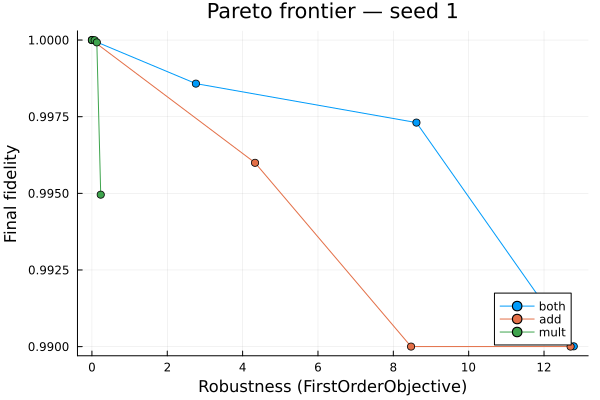

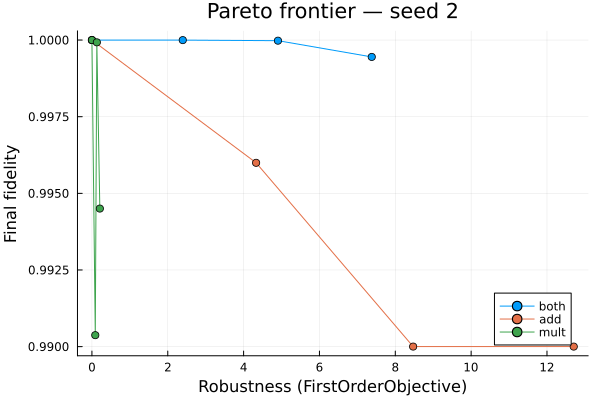

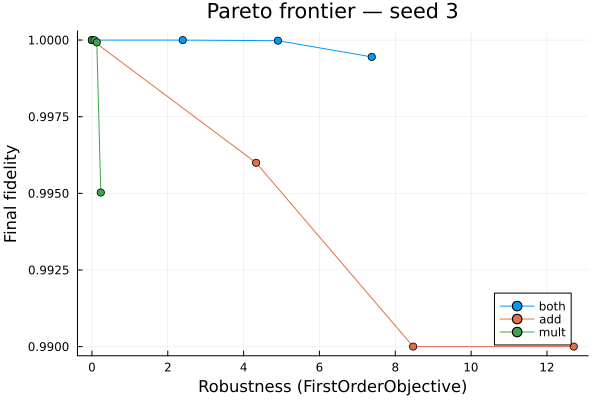

In [10]:
robustness_value(traj::NamedTrajectory, H_err::Function, λ::Float64) = begin
    rob = FirstOrderObjective(H_err, traj; Q_t=λ)  # your safe version
    Z   = vcat(traj.datavec, traj.global_data)
    rob.L(Z)
end

# === 4) collect (robustness, fidelity) and plot Pareto per seed ===
for s in 1:n_seeds
    plt = Plots.plot(
        xlabel="Robustness (FirstOrderObjective)",
        ylabel="Final fidelity",
        title="Pareto frontier — seed $s",
        legend=:bottomright, grid=true
    )
    for (name, H_err) in models
        xs = Float64[]  # robustness
        ys = Float64[]  # fidelity
        for (j, λ) in enumerate(lambdas)
            prob = probs[name][s, j]
            obj = FirstOrderObjective(H_err, prob.trajectory; Q_t=λ)
            Z   = vcat(prob.trajectory.datavec, prob.trajectory.global_data)
            obj_value = obj.L(Z)
            push!(xs, obj_value)
            push!(ys, unitary_rollout_fidelity(prob.trajectory, sys))
        end
        # sort by x for a nice line
        ord = sortperm(xs)
        Plots.plot!(plt, xs[ord], ys[ord], marker=:circle, label=String(name))
    end
    display(plt)
end
